##Pytorch

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

##### softmax and log_softmax

In [ ]:
import math 
z = [1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]
z_exp = [math.exp(i) for i in z]  
print(z_exp)  # Result: [2.72, 7.39, 20.09, 54.6, 2.72, 7.39, 20.09] 

sum_z_exp = sum(z_exp)  
print(sum_z_exp)  # Result: 114.98

softmax = [round(i / sum_z_exp, 3) for i in z_exp]
print(softmax)

[2.718281828459045, 7.38905609893065, 20.085536923187668, 54.598150033144236, 2.718281828459045, 7.38905609893065, 20.085536923187668]
114.98389973429897
[0.024, 0.064, 0.175, 0.475, 0.024, 0.064, 0.175]


In [ ]:
# log_softmax
data=autograd.Variable(torch.FloatTensor([1.0,2.0,3.0]))
log_softmax=F.log_softmax(data,dim=0)
print(log_softmax)

# softmax
softmax=F.softmax(data,dim=0)
print(softmax)


# softmax + log
np_softmax=softmax.data.numpy()
log_np_softmax=np.log(np_softmax)
print(log_np_softmax)

tensor([-2.4076, -1.4076, -0.4076])
tensor([0.0900, 0.2447, 0.6652])
[-2.407606   -1.407606   -0.40760598]


#### KL divergence  KL散度  条件熵

KL散度是不对称的，也就是log(q|p)和log(p|q) 结果不同

In [ ]:
p = torch.tensor([0.4,0.4,0.2],dtype=torch.float32)
q = torch.tensor([0.5,0.1,0.4],dtype=torch.float32)

In [ ]:
# 默认是这种计算 p * log(p/q)  再求和
(p * torch.log(p/q)).sum()

(p * (p/q).log()).sum()

tensor(0.3266)

In [ ]:
# torch的设计是q.log 和p
F.kl_div(q.log(),p,reduction='sum')

tensor(0.3266)

In [ ]:
# KLDivLoss类实现
loss_f = nn.KLDivLoss(reduce=False,reduction='sum')
loss_f(q.log(),p).sum()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(0.3266)

#### 1.Soft Target (base distillation method by hinton)



```

```

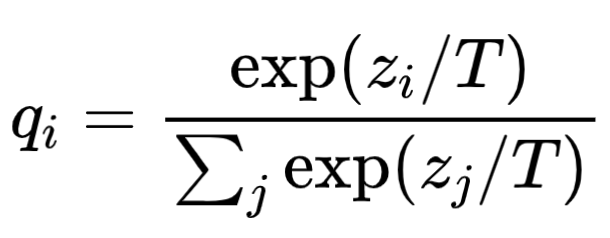

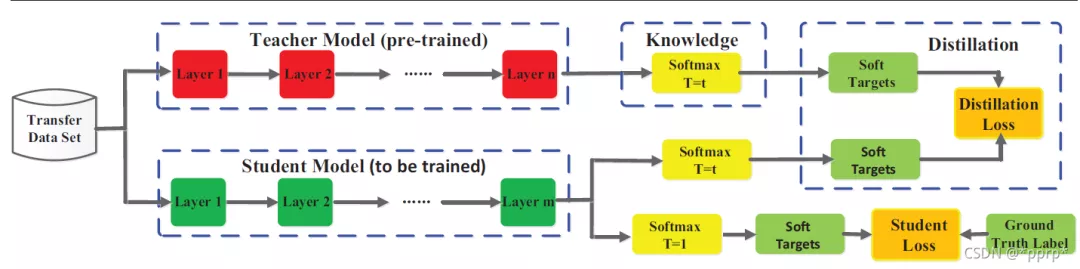

In [ ]:
class SoftTarget(nn.Module):
  def __init__(self,T) -> None:
      '''
      Distilling the Knowledge in a Neural Network
      https://arxiv.org/pdf/1503.02531.pdf
      '''
      super(SoftTarget).__init__()
      self.T = T
  
  def forward(self,out_s,out_t):
    log_out_s = F.log_softmax(out_s/self.T, dim=1)
    out_t = F.softmax(out_t)
    loss = F.kl_div(log_out_s,out_t,reduction="batchmean") * self.T * self.T
    return loss

In [ ]:
# 超参数 alpha，用于调和student网络的hard label loss 和 与teacher model的soft target loss
# 其中y是student的logits输出，labels是ground truth;teacher_scores是teacher model的logits,temp是温度temperature,alpha是超参数
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


def distillation(y, teacher_scores, labels, T, alpha):
    p = F.log_softmax(y/T, dim=1)
    q = F.softmax(teacher_scores/T, dim=1)
    l_kl = F.kl_div(p, q, size_average=False) * (T**2) / y.shape[0]
    l_ce = F.cross_entropy(y, labels)
    return l_kl * alpha + l_ce * (1. - alpha)

#### AT(attention transfer)

求和：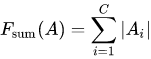



求P范数（p>1）：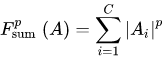


求max P范数（p>1）: 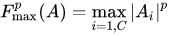

In [ ]:
class AT(nn.Module):
  '''
  Paying More Attention to Attention:Improving the Performance of Convolutional Neural Netkworks via Attention Transfer
  https://arxiv.org/pdf/1612.03928.pdf
  '''
  def __init__(self,p):
    super(AT,self).__init__()
    # P范数(p>1)
    self.p = p

  def forward(self,fm_s,fm_t):
    loss = F.mse_loss(self.attention_map(fm_s),self.attention_map(fm_t))
    return loss

  def at(self,x):
    '''
    https://github.com/szagoruyko/attention-transfer/blob/master/utils.py
    与下面的attention_map方法效果相同，但更具有普遍性
    '''
    return F.normalize(x.pow(2).mean(1).view(x.size(0),-1))

  def attention_map(self,fm,eps=1e-6):
    am = torch.pow(torch.abs(fm),self.p)
    # sum + norm 相当于at方法中的mean(1)
    am = torch.sum(am,dim=1,keepdim=True)
    norm = torch.norm(am,dim=(2,3),keepdim=True)
    am = torch.div(am,norm+eps)
    return am

In [ ]:
'''
对比at和attention_map方法
'''

import numpy as np
# torch.abs()

t = torch.from_numpy(np.array([
                               [
                                [-0.1,-0.2,-0.5],
                                [-0.3,-0.4,0.8]],
                               [[-0.15,-0.3,-0.4],
                                [-0.4,-0.5,0.9]
                                ]
                              ]))
print(t.shape)
am = torch.pow(t,2)
am = torch.sum(am,dim=1,keepdim=True)
norm = torch.norm(am,dim=(1,2),keepdim=True)

am = torch.div(am,norm+1e-6)
am,am.shape

torch.Size([2, 2, 3])


(tensor([[[0.1090, 0.2179, 0.9699]],
 
         [[0.1748, 0.3257, 0.9292]]], dtype=torch.float64),
 torch.Size([2, 1, 3]))

In [ ]:
t,t.view(t.size(0),-1).shape

(tensor([[[-0.1000, -0.2000, -0.5000],
          [-0.3000, -0.4000,  0.8000]],
 
         [[-0.1500, -0.3000, -0.4000],
          [-0.4000, -0.5000,  0.9000]]], dtype=torch.float64),
 torch.Size([2, 6]))

```
torch.view
需要铺平第一个维度就用在第几个维度上用-1
比如[2,1,3] 想要在第二维度铺平 torch.view(2,-1),就会变成[2,3]
```

In [ ]:
ttt = am.view(am.size(0),-1)
ttt,ttt.shape

(tensor([[0.1090, 0.2179, 0.9699],
         [0.1090, 0.2179, 0.9699]], dtype=torch.float64), torch.Size([2, 3]))

In [ ]:
print(t.size())
F.normalize(t.pow(2).mean(1).view(t.size(0),-1))

torch.Size([2, 2, 3])


tensor([[0.1090, 0.2179, 0.9699],
        [0.1090, 0.2179, 0.9699]], dtype=torch.float64)

In [ ]:
t.mean(1).view(t.size(0),-1)

tensor([[-0.2000, -0.3000,  0.1500],
        [-0.2000, -0.3000,  0.1500]], dtype=torch.float64)

#### Fitnet

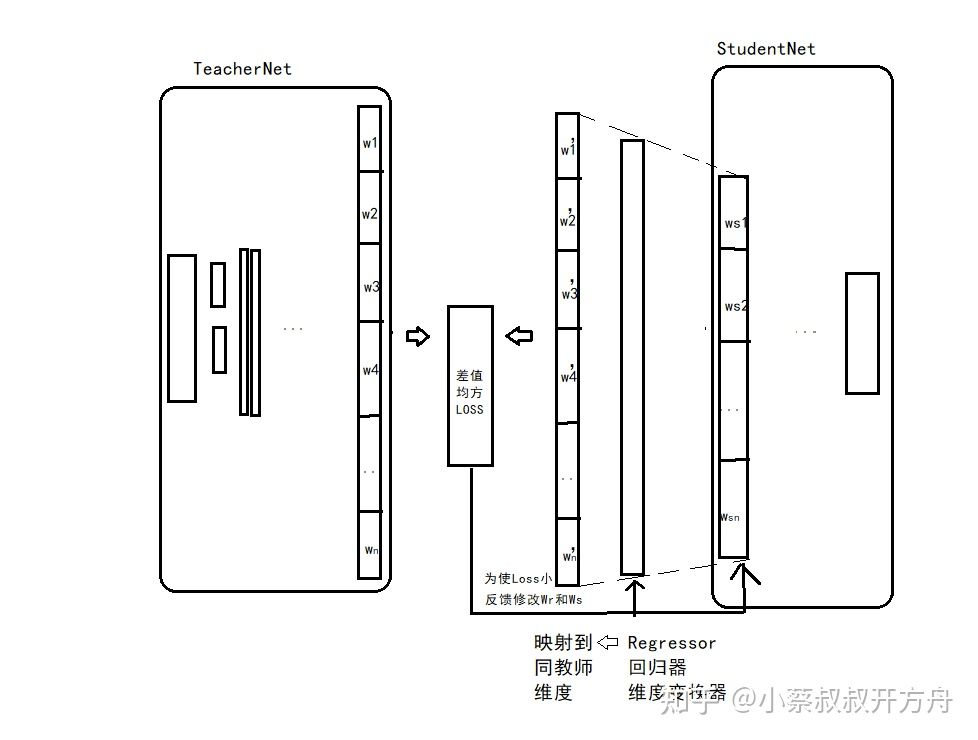

1）确定教师网络，并训练成熟，将教师网络的中间层hint层提取出来；   
2）设定学生网络，该网络一般较教师网络更窄、更深，将学生网络的中间层guided层提取出来；  
3）由于guided层比与hint层窄，因此在guided层后添加回归器用于特征升维，以匹配hint层特征输出；  
4）通过计算hint层的特征输出与回归器转化后的guided层特征均方差，即计算二者特征的距离，距离越短说明Loss越小，两者功能越接近，知识蒸馏越彻底。  

In [ ]:
# https://zhuanlan.zhihu.com/p/410357040

class Hint(nn.Module):
	'''
	FitNets: Hints for Thin Deep Nets
	https://arxiv.org/pdf/1412.6550.pdf
	'''
	def __init__(self):
		super(Hint, self).__init__()

	def forward(self, fm_s, fm_t):
		loss = F.mse_loss(fm_s, fm_t)
		return loss

#### NST neural selective transfer

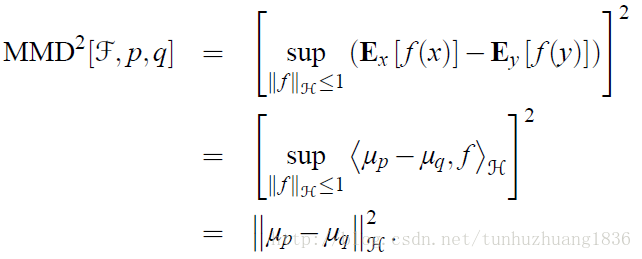

In [ ]:
'''
NST with Polynomial Kernel, where d=2 and c=0

参考链接：
1.https://zhuanlan.zhihu.com/p/25418364
2.https://blog.csdn.net/tunhuzhuang1836/article/details/78058184
'''
class NST(nn.Module):
	'''
	Like What You Like: Knowledge Distill via Neuron Selectivity Transfer
	https://arxiv.org/pdf/1707.01219.pdf
	'''
	def __init__(self):
		super(NST, self).__init__()

	def forward(self, fm_s, fm_t):
		'''
		||u_p - u_q|| ^ 2
		'''
		fm_s = fm_s.view(fm_s.size(0), fm_s.size(1), -1)
		fm_s = F.normalize(fm_s, dim=2)

		fm_t = fm_t.view(fm_t.size(0), fm_t.size(1), -1)
		fm_t = F.normalize(fm_t, dim=2)

		loss = self.poly_kernel(fm_t, fm_t).mean() \
			 + self.poly_kernel(fm_s, fm_s).mean() \
			 - 2 * self.poly_kernel(fm_s, fm_t).mean()

		return loss

	def poly_kernel(self, fm1, fm2):
		fm1 = fm1.unsqueeze(1)
		fm2 = fm2.unsqueeze(2)
		out = (fm1 * fm2).sum(-1).pow(2)

		return out

In [ ]:
'''
Adopted from https://github.com/passalis/probabilistic_kt/blob/master/nn/pkt.py
'''
class PKTCosSim(nn.Module):
	'''
	Learning Deep Representations with Probabilistic Knowledge Transfer
	http://openaccess.thecvf.com/content_ECCV_2018/papers/Nikolaos_Passalis_Learning_Deep_Representations_ECCV_2018_paper.pdf
	'''
	def __init__(self):
		super(PKTCosSim, self).__init__()

	def forward(self, feat_s, feat_t, eps=1e-6):
		# Normalize each vector by its norm
		feat_s_norm = torch.sqrt(torch.sum(feat_s ** 2, dim=1, keepdim=True))
		feat_s = feat_s / (feat_s_norm + eps)
		feat_s[feat_s != feat_s] = 0

		feat_t_norm = torch.sqrt(torch.sum(feat_t ** 2, dim=1, keepdim=True))
		feat_t = feat_t / (feat_t_norm + eps)
		feat_t[feat_t != feat_t] = 0

		# Calculate the cosine similarity
		feat_s_cos_sim = torch.mm(feat_s, feat_s.transpose(0, 1))
		feat_t_cos_sim = torch.mm(feat_t, feat_t.transpose(0, 1))

		# Scale cosine similarity to [0,1]
		feat_s_cos_sim = (feat_s_cos_sim + 1.0) / 2.0
		feat_t_cos_sim = (feat_t_cos_sim + 1.0) / 2.0

		# Transform them into probabilities
		feat_s_cond_prob = feat_s_cos_sim / torch.sum(feat_s_cos_sim, dim=1, keepdim=True)
		feat_t_cond_prob = feat_t_cos_sim / torch.sum(feat_t_cos_sim, dim=1, keepdim=True)

		# Calculate the KL-divergence
		loss = torch.mean(feat_t_cond_prob * torch.log((feat_t_cond_prob + eps) / (feat_s_cond_prob + eps)))

		return loss

#### FSP

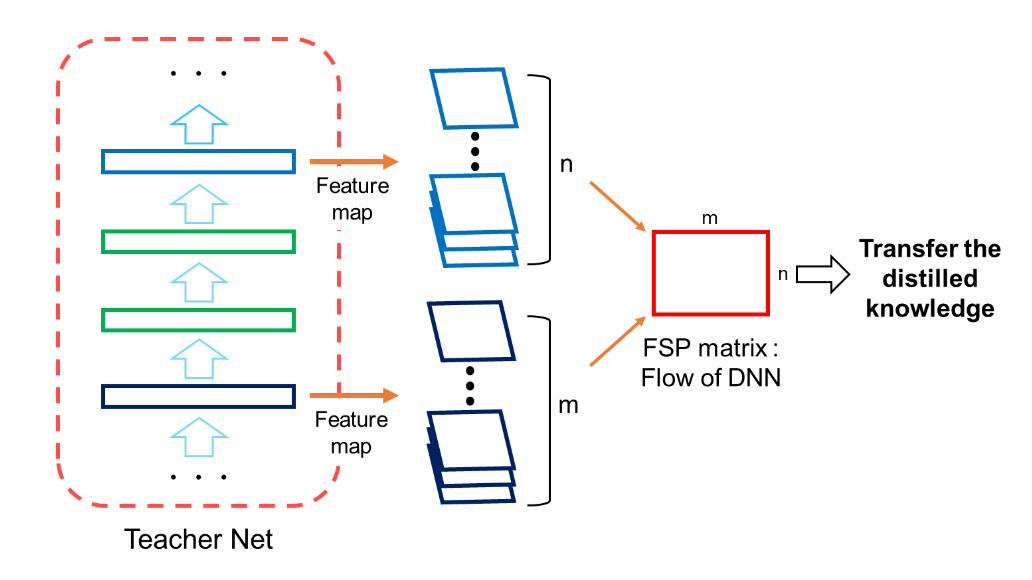

In [ ]:
class FSP(nn.Module):
	'''
	A Gift from Knowledge Distillation: Fast Optimization, Network Minimization and Transfer Learning
	http://openaccess.thecvf.com/content_cvpr_2017/papers/Yim_A_Gift_From_CVPR_2017_paper.pdf
	'''
	def __init__(self):
		super(FSP, self).__init__()

	def forward(self, fm_s1, fm_s2, fm_t1, fm_t2):
		loss = F.mse_loss(self.fsp_matrix(fm_s1,fm_s2), self.fsp_matrix(fm_t1,fm_t2))

		return loss

	def fsp_matrix(self, fm1, fm2):
		if fm1.size(2) > fm2.size(2):
			fm1 = F.adaptive_avg_pool2d(fm1, (fm2.size(2), fm2.size(3)))

		fm1 = fm1.view(fm1.size(0), fm1.size(1), -1)
		fm2 = fm2.view(fm2.size(0), fm2.size(1), -1).transpose(1,2)

		fsp = torch.bmm(fm1, fm2) / fm1.size(2)

		return fsp

In [ ]:
m = nn.AdaptiveAvgPool2d((5,7))

input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape

torch.Size([1, 64, 5, 7])

In [ ]:
F.adaptive_avg_pool2d(input,(5,7)).shape

torch.Size([1, 64, 5, 7])

#### FT (factor transfer)

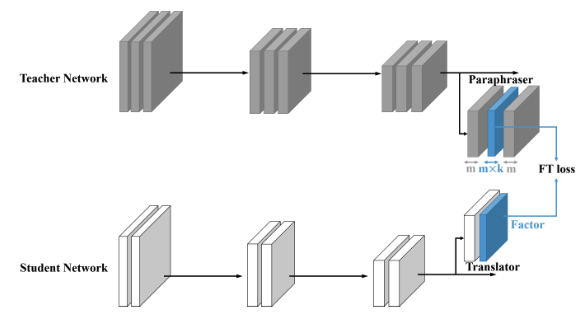

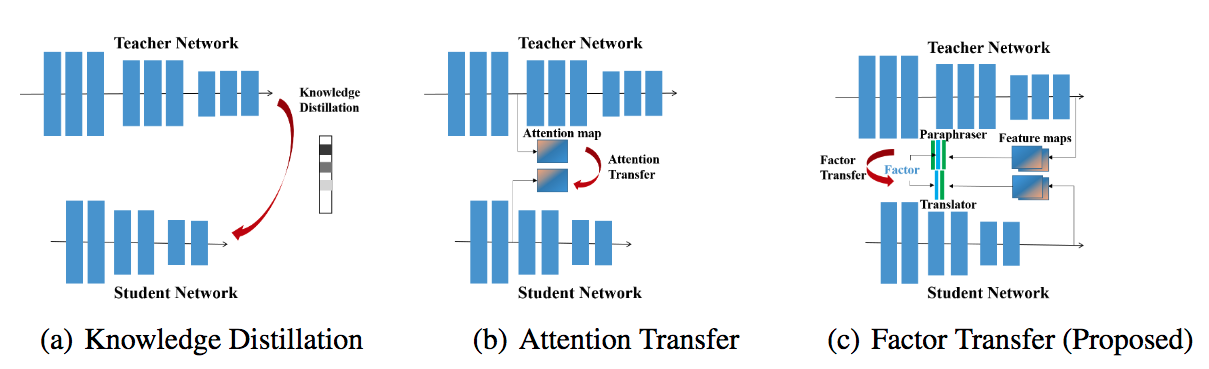


```
不直接对比softened distribution(KD) or the attention_map(AT) which is defined as
the sum of feature maps of the teacher and the student networkds.
从tearcher和student中抽取factors

paraphraser是m (m*k)-> m * k (k*m)-> m
简单说就是teacher利用feature_maps后作了一个类似于FFN(autoencoder)的操作，先映射到低维再映射回高维，中间的m*k是factor;student利用一个translator模块将feature_map映射到m*k维度
```

In [ ]:
from torch.autograd import Variable,Function

class ParaPhraser(nn.Module):
  def __init__(self,in_planes,planes,stride=1):
    super(ParaPhraser,self).__init__()
    self.leakyrelu = nn.LeakyReLU(0.1)
#      self.bn0 = nn.BatchNorm2d(in_planes)
    self.conv0 = nn.Conv2d(in_planes,in_planes , kernel_size=3, stride=1, padding=1, bias=True)
#      self.bn1 = nn.BatchNorm2d(planes)
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=True)
#      self.bn2 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=True)
#      self.bn0_de = nn.BatchNorm2d(planes)
    self.deconv0 = nn.ConvTranspose2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=True)
#      self.bn1_de = nn.BatchNorm2d(in_planes)
    self.deconv1 = nn.ConvTranspose2d(planes,in_planes, kernel_size=3, stride=1, padding=1, bias=True)
#      self.bn2_de = nn.BatchNorm2d(in_planes)
    self.deconv2 = nn.ConvTranspose2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=True)

  '''
  mode 0: throw encoder and decoder (reconstruction) 
  mode 1: extracting teacher factors
  '''
  def forward(self,x,mode):
    if mode == 0:
      ## encoder
      out = self.leakyrelu(self.conv0(x))
      out = self.leakyrelu((self.conv1(out)))
      out = self.leakyrelu((self.conv2(out)))
      ## decoder
      out = self.leakyrelu(self.deconv0(out))
      out = self.leakyrelu(self.deconv1(out))
      out = self.leakeyrelu(self.deconv2(out))

    if mode == 1:
      out = self.leakyrelu(self.conv0(x))
      out = self.leakyrelu((self.conv1(out)))
      out = self.leakyrelu((self.conv2(out)))
    
    ## only throw decoder
    if mode == 2:
      out = self.leakyrelu((self.deconv0(x)))
      out = self.leakyrelu((self.deconv1(out)))
      out = self.leakyrelu((self.deconv2(out)))

    return out


class Translator(nn.Module):
  def __init__(self,in_planes, planes, stride=1):
        super(Translator, self).__init__()
        self.leakyrelu = nn.LeakyReLU(0.1)
  #      self.bn0 = nn.BatchNorm2d(in_planes)
        self.conv0 = nn.Conv2d(in_planes,in_planes , kernel_size=3, stride=1, padding=1, bias=True)
  #     self.bn1 = nn.BatchNorm2d(planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=True)
  #     self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=True)

  def forward(self, x):
      out = self.leakyrelu((self.conv0(x)))
      out = self.leakyrelu((self.conv1(out)))
      out = self.leakyrelu((self.conv2(out)))
      return out

'''
先train teacher和paraphraser
然后train student 同时有hard label loss和 soft loss


Teacher = ResNet56()
Student = ResNet20()


teacher_outputs = teacher(inputs)
student_outputs = student(inputs)

factor_t = module_t(teacher_outputs[2],1)
factor_s = module_t(student_outpus[2])

对应下面的class FT
loss = BETA * (criterion(utils.FT(factor_s), utils.FT(factor_t.detach()))) \
               + criterion_CE(student_outputs[3], targets)

def FT(x):
    return F.normalize(x.view(x.size(0), -1))
'''


In [ ]:
class FT(nn.Module):
  '''
	araphrasing Complex Network: Network Compression via Factor Transfer
	http://papers.nips.cc/paper/7541-paraphrasing-complex-network-network-compression-via-factor-transfer.pdf
  # 原作者代码: https://github.com/Jangho-Kim/Factor-Transfer-pytorch
	'''
  def __init__(FT,self):
    super(FT,self).__init__()

  def forward(self,factor_s,factor_t):
    loss = F.l1_loss(self.normalize(factor_s),self.normalize(factor_t))
    return loss

  def normalize(self,factor):
    normal_factor = F.normalize(factor.view(factor.size(0),-1))
    return normal_factor

#### RKD(Relational Knowledge Distillation)

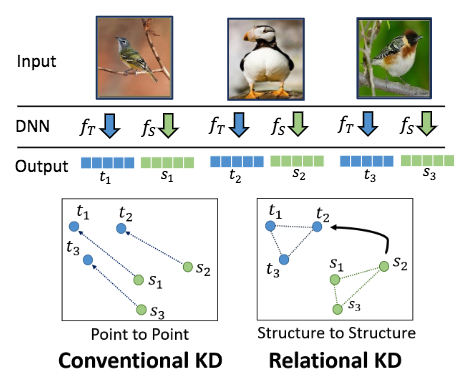

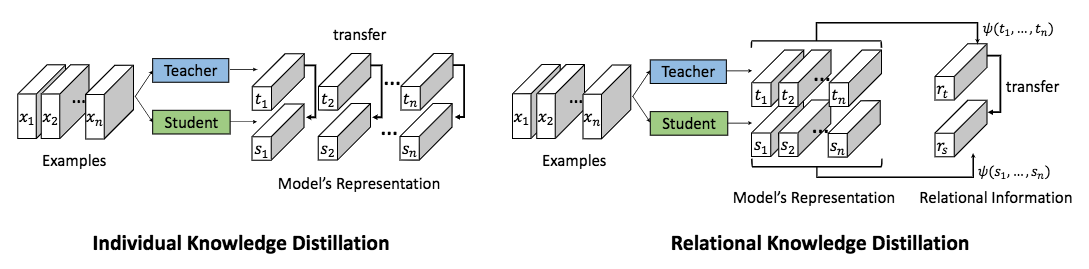


##### pair of examples
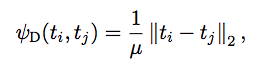

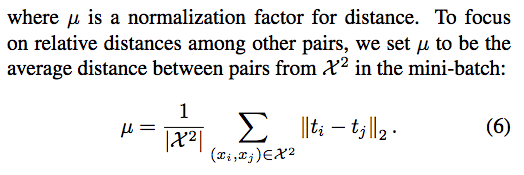

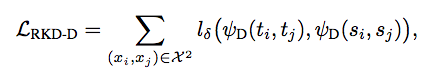

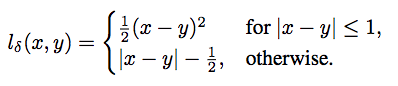

### triple of examples

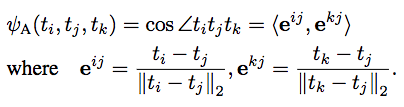

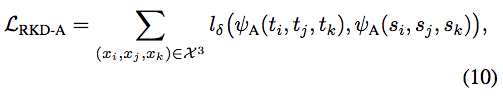

In [ ]:
'''
From https://github.com/lenscloth/RKD/blob/master/metric/loss.py
'''
class RKD(nn.Module):
	'''
	Relational Knowledge Distillation
	https://arxiv.org/pdf/1904.05068.pdf
	'''
	def __init__(self, w_dist, w_angle):
		super(RKD, self).__init__()

		self.w_dist  = w_dist
		self.w_angle = w_angle

	def forward(self, feat_s, feat_t):
		loss = self.w_dist * self.rkd_dist(feat_s, feat_t) + \
			   self.w_angle * self.rkd_angle(feat_s, feat_t)

		return loss

	def rkd_dist(self, feat_s, feat_t):
		feat_t_dist = self.pdist(feat_t, squared=False)
		mean_feat_t_dist = feat_t_dist[feat_t_dist>0].mean()
		feat_t_dist = feat_t_dist / mean_feat_t_dist

		feat_s_dist = self.pdist(feat_s, squared=False)
		mean_feat_s_dist = feat_s_dist[feat_s_dist>0].mean()
		feat_s_dist = feat_s_dist / mean_feat_s_dist

		loss = F.smooth_l1_loss(feat_s_dist, feat_t_dist)

		return loss

	def rkd_angle(self, feat_s, feat_t):
		# N x C --> N x N x C
		feat_t_vd = (feat_t.unsqueeze(0) - feat_t.unsqueeze(1))
		norm_feat_t_vd = F.normalize(feat_t_vd, p=2, dim=2)
		feat_t_angle = torch.bmm(norm_feat_t_vd, norm_feat_t_vd.transpose(1, 2)).view(-1)

		feat_s_vd = (feat_s.unsqueeze(0) - feat_s.unsqueeze(1))
		norm_feat_s_vd = F.normalize(feat_s_vd, p=2, dim=2)
		feat_s_angle = torch.bmm(norm_feat_s_vd, norm_feat_s_vd.transpose(1, 2)).view(-1)

		loss = F.smooth_l1_loss(feat_s_angle, feat_t_angle)

		return loss

	def pdist(self, feat, squared=False, eps=1e-12): # 通过矩阵直接计算邻接问题
		feat_square = feat.pow(2).sum(dim=1)
		feat_prod   = torch.mm(feat, feat.t())
		feat_dist   = (feat_square.unsqueeze(0) + feat_square.unsqueeze(1) - 2 * feat_prod).clamp(min=eps) # 等同于np.clip

		if not squared:
			feat_dist = feat_dist.sqrt()

		feat_dist = feat_dist.clone()
		feat_dist[range(len(feat)), range(len(feat))] = 0 # 对角线置0

		return feat_dist

### AB(activation boundary)

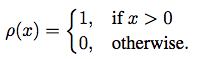

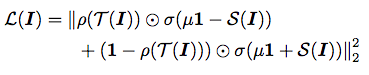

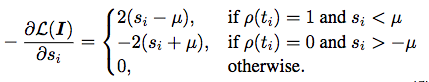

In [ ]:
class AB(nn.Module):
  '''
	Knowledge Transfer via Distillation of Activation Boundaries Formed by Hidden Neurons
	https://arxiv.org/pdf/1811.03233.pdf
	'''
  def __init__(self,margin):
    super(AB,self).__init__()
    self.margin = margin

  def forward(self,fm_s,fm_t):
    # fm before activation
    '''(fm_s > -self.margin) & (fm_t <=0) 对应的是 s_i > μ and ρ(t_i) = 0  此时fm_t <=0 所以ρ(t_i) = 0  此时ρ函数是relu激活函数的导数 relu = max(0,x) => relu' = max(0,1)
       (fm_s <= self.margin) & (fm_t > 0) 对应的是 s_i < μ and ρ(t_i) = 1 此时 fm_t >0 所以 ρ(t_i) = 1
       ((fm_s > -self.margin) & (fm_t <= 0)).float() 没有平方的原因是因为元素都是0和1  平方之后也没有意义，是一样的？？？
    '''
    loss = ((fm_s + self.margin).pow(2) * ((fm_s > -self.margin) & (fm_t <= 0)).float() + 
            (fm_s - self.margin).pow(2) * ((fm_s <= self.margin) & (fm_t > 0)).float()
            )
    # 原文的方式是 torch.abs(loss).sum()
    loss = loss.mean()
    return loss

In [ ]:
a = np.array([-1,1,1,0])
b = np.array([-1,0,1,1])
# 全部都是0和1的矩阵 求几次方之后也没有用
np.array((a > 0) & (b > 0),np.float32)

array([0., 0., 1., 0.], dtype=float32)

### SP (similarity preservation)

In [ ]:
class SP(nn.Module):
	'''
	Similarity-Preserving Knowledge Distillation
	https://arxiv.org/pdf/1907.09682.pdf
	'''
	def __init__(self):
		super(SP, self).__init__()

	def forward(self, fm_s, fm_t):
		fm_s = fm_s.view(fm_s.size(0), -1)
		G_s  = torch.mm(fm_s, fm_s.t())
		norm_G_s = F.normalize(G_s, p=2, dim=1)

		fm_t = fm_t.view(fm_t.size(0), -1)
		G_t  = torch.mm(fm_t, fm_t.t())
		norm_G_t = F.normalize(G_t, p=2, dim=1)

		loss = F.mse_loss(norm_G_s, norm_G_t)

		return loss

In [ ]:
a = torch.tensor([[[2,3,4],[1,2,3]],[[2,4,5],[6,7,8]]])
a = a.view(a.size(0),-1)
torch.mm(a,a.t())

tensor([[ 43,  80],
        [ 80, 194]])

### Sobolev (sobolev/jacobian matching) 

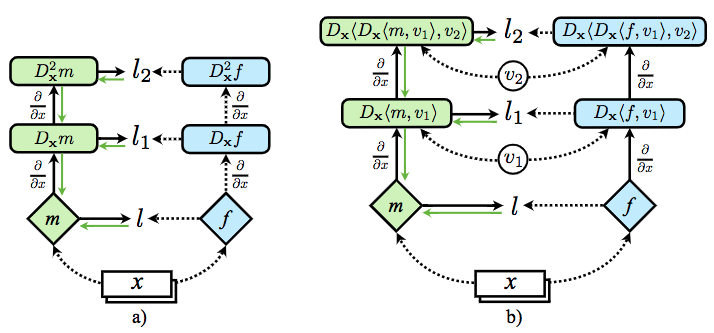


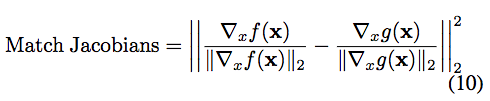

In [ ]:
from torch.autograd import grad

class Sobolev(nn.Module):
	'''
	Sobolev Training for Neural Networks
	https://arxiv.org/pdf/1706.04859.pdf
	Knowledge Transfer with Jacobian Matching  # 该篇论文
	http://de.arxiv.org/pdf/1803.00443
	'''
	def __init__(self):
		super(Sobolev, self).__init__()

	def forward(self, out_s, out_t, img, target):
		'''target是目标输出维度'''
		target_out_s = torch.gather(out_s, 1, target.view(-1, 1))
		grad_s = grad(
				outputs=target_out_s, 
				inputs=img,
				grad_outputs=torch.ones_like(target_out_s),
				create_graph=True, 
				retain_graph=True, 
				only_inputs=True)[0] # grad返回结果是一个tuple
		norm_grad_s  = F.normalize(grad_s.view(grad_s.size(0), -1), p=2, dim=1)

		target_out_t = torch.gather(out_t, 1, target.view(-1, 1))
		grad_t = grad(
				outputs=target_out_t, 
				inputs=img,
				grad_outputs=torch.ones_like(target_out_t),
				create_graph=True, 
				retain_graph=True, 
				only_inputs=True)[0]
		norm_grad_t  = F.normalize(grad_t.view(grad_t.size(0), -1), p=2, dim=1)

		loss = F.mse_loss(norm_grad_s, norm_grad_t.detach())

		return loss

###### torch.gather

```
out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2

>>> t = torch.tensor([[1, 2], [3, 4]])
>>> torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]]))
tensor([[ 1,  1],
        [ 4,  3]])
```

###### torch.autograd.grad
  ```
  如果输入x，输出是y，则求y关于x的导数（梯度）
  ```

In [ ]:
x = torch.randn(3, 4).requires_grad_(True)
print(x)
y = x ** 2
weight = torch.ones(y.size())
print(weight)

dydx = torch.autograd.grad(outputs=y,
                           inputs=x,
                           grad_outputs=weight,
                           retain_graph=True,
                           create_graph=True,
                           only_inputs=True)


print(x[0][0])

t = np.ones((3,4))
nx = x.detach().numpy()
for i in range(3):
  for j in range(4):
    t[i][j] = np.around(2 * nx[i][j], decimals=4, out=None)

print(t)

print(dydx)

tensor([[ 0.6624, -0.4752, -0.5573, -0.3902],
        [-1.2552,  0.0417, -2.4158, -0.9036],
        [ 0.4464,  0.0822,  0.8120,  0.0583]], requires_grad=True)
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor(0.6624, grad_fn=<SelectBackward0>)
[[ 1.3248 -0.9505 -1.1145 -0.7804]
 [-2.5104  0.0834 -4.8316 -1.8072]
 [ 0.8927  0.1644  1.624   0.1166]]
(tensor([[ 1.3248, -0.9505, -1.1145, -0.7804],
        [-2.5104,  0.0834, -4.8316, -1.8072],
        [ 0.8927,  0.1644,  1.6240,  0.1166]], grad_fn=<MulBackward0>),)


### BSS (boundary supporting samples)
```
TODO: 对抗学习思路  不了解
```

In [ ]:
# from torch.autograd.gradcheck import zero_gradients

'''
Modified by https://github.com/bhheo/BSS_distillation
'''
def reduce_sum(x,keepdim=True):
  for d in reversed(range(1,x.dim())):
    x = x.sum(d,keepdim=keepdim)
    return x

def l2_norm(x,keepdim=True):
  norm = reduce_sum(x*x,keepdim=keepdim)
  return norm.sqrt()


class BSS(nn.Module):
  '''
	Knowledge Distillation with Adversarial Samples Supporting Decision Boundary
	https://arxiv.org/pdf/1805.05532.pdf
	'''
  def __init__(self,T):
    super(BSS,self).__init__()
    self.T = T
  
  def forward(self,attacked_out_s,attacked_out_t):
    loss = F.kl_div(
        F.log_softmax(attacked_out_s/self.T,dim=1),
        F.softmax(attacked_out_t/self.T,dim=1),
        reduction='batchmean'
    ) # * self.T * self.T
    return loss

class BSSAttacker():
  def __init__(self,step_alpha,num_steps,eps=1e-4):
    self.step_alpha = step_alpha
    self.num_steps = num_steps
    self.eps = eps

  def attack(self,model,img,target,attack_class):
    img = img.detach().require_grad_(True)
    step = 0
    while step < self.num_steps:
      img.zero_grad_() # zero_gradients 方法在新的torch中已经弃用
      _,_,_,_,output = model(img)
      score = F.softmax(output,dim=1)
      score_target = score.gather(1,target.unsqueeze(1))
      score_attack_class = score.gather(1, attack_class.unsqueeze(1))

      loss = (score_attack_class - score_target).sum()
      loss.backward()

      step_alpha = self.step_alpha * (target == output.max(1)[1]).float()
      step_alpha = step_alpha.unsqueeze(1).unsqueeze(1).unsqueeze(1)
      if step_alpha.sum() == 0:
        break
      pert = (score_target - score_attack_class).unsqueeze(1).unsqueeze(1)
      norm_pert = step_alpha * (pert + self.eps) * img.grad / l2_norm(img.grad)

      step_adv = img + norm_pert
      step_adv = torch.clamp(step_adv, -2.5, 2.5)
      img.data = step_adv.data

      step += 1
    return img

### CC (correlation congruence)


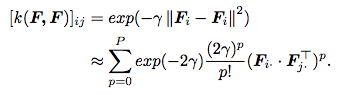

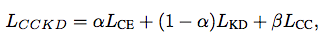

In [ ]:
import math

# file:///Users/bello/Downloads/16865-Article%20Text-20359-1-2-20210518.pdf 这篇文非常相似

'''
CC with P-order Taylor Expansion of Gaussian RBF kernel
'''
class CC(nn.Module):
	'''
	Correlation Congruence for Knowledge Distillation
	http://openaccess.thecvf.com/content_ICCV_2019/papers/
	Peng_Correlation_Congruence_for_Knowledge_Distillation_ICCV_2019_paper.pdf
	'''
	def __init__(self, gamma, P_order):
		super(CC, self).__init__()
		self.gamma = gamma
		self.P_order = P_order

	def forward(self, feat_s, feat_t):
		corr_mat_s = self.get_correlation_matrix(feat_s)
		corr_mat_t = self.get_correlation_matrix(feat_t)

		loss = F.mse_loss(corr_mat_s, corr_mat_t)

		return loss

	def get_correlation_matrix(self, feat):
    # 关注的是样本之间的相关度，通过相关系数矩阵然后衡量teacher与student coef matrix的差异 是否可以考虑用coef方式???
		feat = F.normalize(feat, p=2, dim=-1)
		sim_mat  = torch.matmul(feat, feat.t())
		corr_mat = torch.zeros_like(sim_mat)

    # 使用的是rbf kernel的taylor展开式近似
		for p in range(self.P_order+1):
			corr_mat += math.exp(-2*self.gamma) * (2*self.gamma)**p / \
						math.factorial(p) * torch.pow(sim_mat, p)

		return corr_mat

```
F.norm之后L2-norm之后再乘以自己，sim_mat其实就是一个单位矩阵
比如矩阵是
```

A = 
$\left(\begin{array}{}
1&2&3\\
4&5&6\\
\end{array}\right)$

```标准化过程是```

$\displaystyle\frac {1} {\sqrt {1^2 + 2 ^ 2 + 3 ^ 2}} = 0.26..$

所以 A * $A^T$ = 

$norm\left(\begin{array}{}
1&2&3\\
4&5&6\\
\end{array}\right)$ * $norm\left(\begin{array}{}
1&4\\
2&5\\
3&6\\
\end{array}\right)$ = 

E[0][0]=
$\displaystyle\frac {1^2} {\sqrt {1^2 + 2 ^ 2 + 3 ^ 2}}  + \displaystyle\frac {2^2} {\sqrt {1^2 + 2 ^ 2 + 3 ^ 2}} + 
\displaystyle\frac {3^3} {\sqrt {1^2 + 2 ^ 2 + 3 ^ 2}} = 1
$


最后结果就是一个单位矩阵

所以泰勒级数展开的$e^{-2γ(x^2 + y^2)} = e ^ {-2γ}$

因为L2-norm自身*L2-norm自身的转置

In [ ]:
a = torch.tensor([[1,2,3],[3,4,5]],dtype=torch.float32)
norm_a = F.normalize(a,p=2,dim=-1)
print(norm_a)
torch.matmul(norm_a,norm_a.t())

tensor([[0.2673, 0.5345, 0.8018],
        [0.4243, 0.5657, 0.7071]])


tensor([[1.0000, 0.9827],
        [0.9827, 1.0000]])

In [ ]:
torch.matmul(a,a.t())

tensor([[14., 26.],
        [26., 50.]])

###### coef 相关系数
```
numpy与torch里面的coef类似
首先通过计算协方差矩阵
```
$\displaystyle\frac {C_{ij}} {\sqrt{C_{ii} * C_{jj}}}$

$cov(x,y) = \displaystyle\frac {\displaystyle\sum_{i=1}^n(x_i - \bar x)(y_i - \bar y)} {N-1}$ 

```
假如只有x,y求协方差矩阵，则矩阵是2*2的方阵
```
$\left(\begin{array}{}
cov(a,a)&cov(a,b)\\
cov(b,a)&cov(b,b)\\
\end{array}\right)$


In [ ]:
'''
refer:
# https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
# https://pytorch.org/docs/stable/generated/torch.corrcoef.html
'''

x = np.array([[0, 1, 2], [2, 1, 0]])
r1 = np.corrcoef(x)
print(r1)

x1 = torch.tensor([[0, 1, 2], [2, 1, 0]])
torch.corrcoef(x1)

[[ 1. -1.]
 [-1.  1.]]


tensor([[ 1., -1.],
        [-1.,  1.]])

In [ ]:
a = torch.tensor([1,1,2])
torch.zeros_like(a)


math.exp(-2*0.01) * (2 * -0.01) ** p / math.factorial(p)

0.9801986733067553

##### 泰勒级数展开

RBF kernel taylor expansion

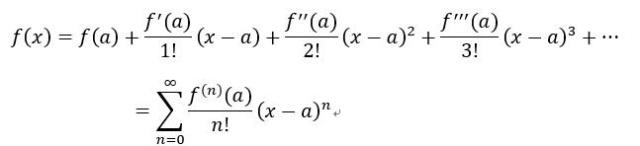
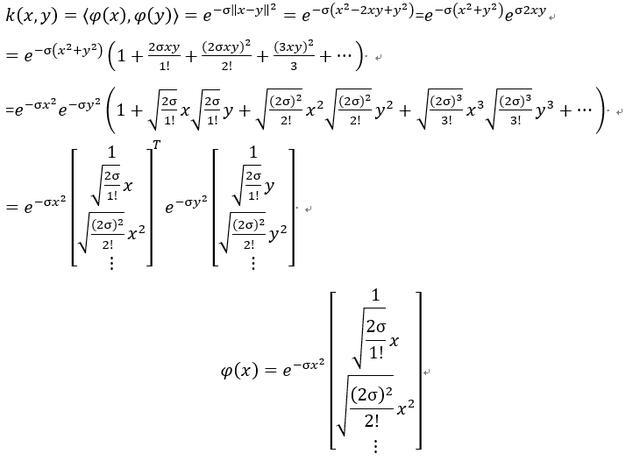

### LwM (learning without memorizing)

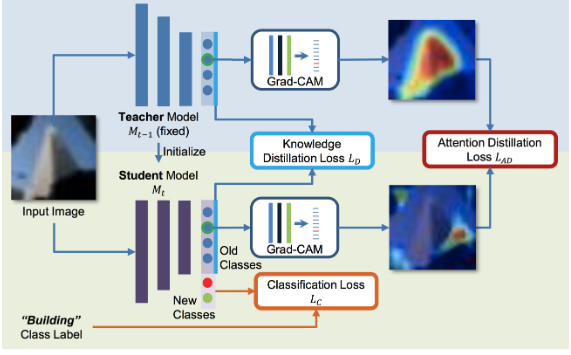

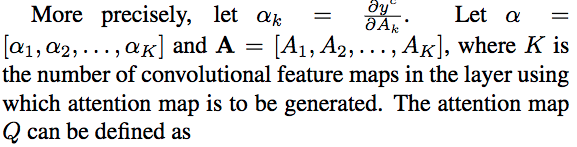

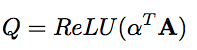

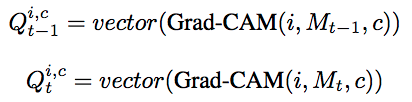

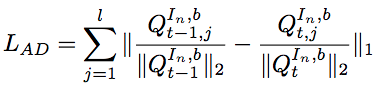

In [ ]:
'''
LwM is originally an incremental learning method with 
classification/distillation/attention distillation losses.
Here, LwM is only defined as the Grad-CAM based attention distillation.

grad-cam 参考
https://github.com/ramprs/grad-cam/

Following this, the gradient of score yc for a
desired class c is computed with respect to each convolu-
tional feature map Ak. For each Ak, global average pooling
is performed to obtain the neuron importance αk of Ak. All
the Ak weighted by αk are passed through a ReLU activa-
tion function to obtain a final attention map for class c.
'''
class LwM(nn.Module):
  '''
	Learning without Memorizing
	https://arxiv.org/pdf/1811.08051.pdf
	'''
  def __init__(self):
    super(LwM,self).__init__()
  
  def forward(self,out_s,fm_s,out_t,fm_t,target):
    target_out_t = torch.gather(out_t,1,target.view(-1,1)) # channel
    grad_fm_t = grad(
        outputs = target_out_t,
        inputs=fm_t,
        grad_outputs=torch.ones_like(target_out_t),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    weights_t = F.adaptive_avg_pool2d(grad_fm_t,1) # global average pooling α_k
    # Q = relu(α^T * A)
    cam_t = torch.sum(torch.mul(weights_t,grad_fm_t),dim=1,keepdim=True)
    cam_t = F.relu(cam_t) 

    # normalize
    cam_t = cam_t.view(cam_t.size(0),-1)
    norm_cam_t = F.normalize(cam_t,p=2,dim=1)

    target_out_s = torch.gather(out_s, 1, target.view(-1, 1))
    grad_fm_s = grad(
      outputs=target_out_s, 
      inputs=fm_s,
      grad_outputs=torch.ones_like(target_out_s),
      create_graph=True, retain_graph=True, only_inputs=True)[0]
    weights_s = F.adaptive_avg_pool2d(grad_fm_s, 1)
    cam_s = torch.sum(torch.mul(weights_s, grad_fm_s), dim=1, keepdim=True)
    cam_s = F.relu(cam_s)
    cam_s = cam_s.view(cam_s.size(0), -1)
    norm_cam_s = F.normalize(cam_s, p=2, dim=1)

    # L1 loss
    loss = F.l1_loss(norm_cam_s,norm_cam_t.detach())
    return loss

### IRG (instance relationship graph)

```
跟前面的CC很像 也是instance feature's loss and relation feature's loss
```

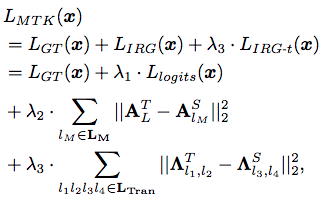

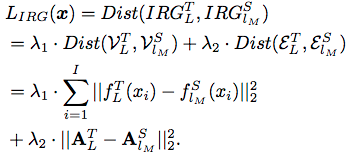

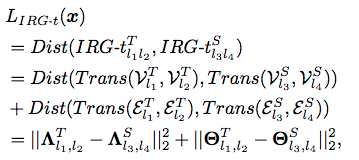

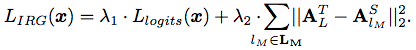

```
def forward(self, x):
		pstem = self.conv1(x) # pstem: pre stem before activation
		pstem = self.bn1(pstem)
		stem  = self.relu(pstem)
		stem  = (pstem, stem)

		rb1 = self.res1(stem[1])
		rb2 = self.res2(rb1[1])
		rb3 = self.res3(rb2[1])

		feat = self.avgpool(rb3[1])
		feat = feat.view(feat.size(0), -1)
		out  = self.fc(feat)

		return stem, rb1, rb2, rb3, feat, out


    stem_s, rb1_s, rb2_s, rb3_s, feat_s, out_s = snet(img)  

    stem_t, rb1_t, rb2_t, rb3_t, feat_t, out_t = tnet(img)  
    kd_loss = criterionKD([rb2_s[1], rb3_s[1], feat_s, out_s],
								  [rb2_t[1].detach(),
								   rb3_t[1].detach(),
								   feat_t.detach(), 
								   out_t.detach()]) * args.
```

In [ ]:
class IRG(nn.Module):
  '''
  Knowledge Distillation via Instance Relationship Graph
  http://openaccess.thecvf.com/content_CVPR_2019/papers/
  Liu_Knowledge_Distillation_via_Instance_Relationship_Graph_CVPR_2019_paper.pdf
  The official code is written by Caffe
  https://github.com/yufanLIU/IRG
  '''
  def __init__(self, w_irg_vert, w_irg_edge, w_irg_tran):
    super(IRG, self).__init__()

    self.w_irg_vert = w_irg_vert
    self.w_irg_edge = w_irg_edge
    self.w_irg_tran = w_irg_tran

  def forward(self,irg_s,irg_t):
    fm_s1,fm_s2,feat_s,out_s = irg_s
    fm_t1, fm_t2, feat_t, out_t = irg_t

    # out_s,out_t就是tearch和student的logits的mse
    loss_irg_vert = F.mse_loss(out_s, out_t)

    # edge feature map多个loss
    irg_edge_feat_s = self.euclidean_dist_feat(feat_s,squared=True)
    irg_edge_feat_t = self.euclidean_dist_feat(feat_t,squared=True)
    irg_edge_fm_s1  = self.euclidean_dist_fm(fm_s1, squared=True)
    irg_edge_fm_t1  = self.euclidean_dist_fm(fm_t1, squared=True)
    irg_edge_fm_s2  = self.euclidean_dist_fm(fm_s2, squared=True)
    irg_edge_fm_t2  = self.euclidean_dist_fm(fm_t2, squared=True)
    loss_irg_edge = (F.mse_loss(irg_edge_feat_s,irg_edge_feat_t) + \
      F.mse_loss(irg_edge_fm_s1,irg_edge_fm_t1) + \
      F.mse_loss(irg_edge_fm_s2,irg_edge_fm_t2)) / 3

    # trans
    irg_tran_s = self.euclidean_dis_fms(fm_s1,fm_s2,squared=True)
    irg_tran_t = self.euclidean_dis_fms(fm_t1,fm_t2,squared=True)
    loss_irg_tran = F.mse_loss(irg_tran_s,irg_tran_t)

    loss = (self.w_irg_vert * loss_irg_vert + self.w_irg_edge * loss_irg_edge + self.w_irg_tran * loss_irg_tran)
    return loss

  def euclidean_dis_fms(self,fm1,fm2,squared=False,eps=1e-12):
    '''
    Calculating the IRG Transformation, where fm1 precedes fm2 in the network.
    '''
    if fm1.size(2) > fm2.size(2):
      fm1 = F.adaptive_avg_pool2d(fm1, (fm2.size(2), fm2.size(3)))
    if fm1.size(1) < fm2.size(1):
      fm2 = (fm2[:,0::2,:,:] + fm2[:,1::2,:,:]) / 2.0
    fm1 = fm1.view(fm1.size(0), -1)
    fm2 = fm2.view(fm2.size(0), -1)
    fms_dist = torch.sum(torch.pow(fm1-fm2, 2), dim=-1).clamp(min=eps)
    if not squared:
      fms_dist = fms_dist.sqrt()
    fms_dist = fms_dist / fms_dist.max()
    return fms_dist

  def euclidean_dist_fm(self, fm, squared=False, eps=1e-12): 
    '''
    Calculating the IRG edge of feature map. 
    '''
    fm = fm.view(fm.size(0), -1)
    fm_square = fm.pow(2).sum(dim=1)
    fm_prod = torch.mm(fm, fm.t())
    fm_dist = (fm_square.unsqueeze(0) + fm_square.unsqueeze(1) - 2 * fm_prod).clamp(min=eps)

    if not squared:
      fm_dist = fm_dist.sqrt()

    fm_dist = fm_dist.clone()
    fm_dist[range(len(fm)), range(len(fm))] = 0
    fm_dist = fm_dist / fm_dist.max()

    return fm_dist

  def euclidean_dist_feat(self, feat, squared=False, eps=1e-12):
    '''
    Calculating the IRG edge of feat.
    '''
    feat_square = feat.pow(2).sum(dim=1)
    feat_prod   = torch.mm(feat, feat.t())
    feat_dist   = (feat_square.unsqueeze(0) + feat_square.unsqueeze(1) - 2 * feat_prod).clamp(min=eps)

    if not squared:
      feat_dist = feat_dist.sqrt()

    feat_dist = feat_dist.clone()
    feat_dist[range(len(feat)), range(len(feat))] = 0
    feat_dist = feat_dist / feat_dist.max()

    return feat_dist

### VID (variational information distillation)

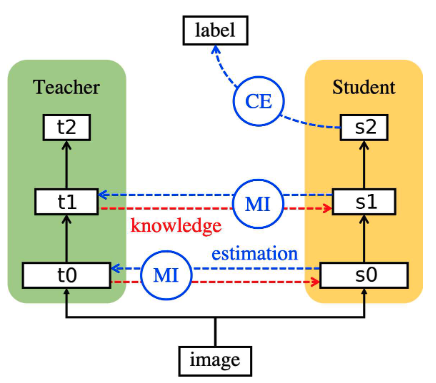

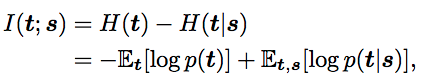

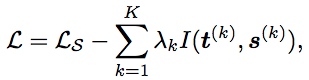

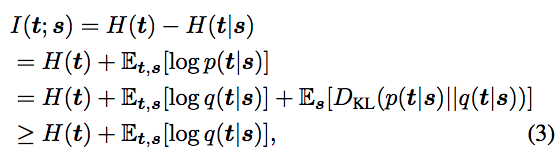

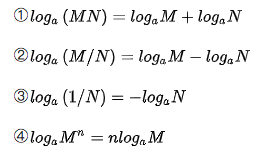

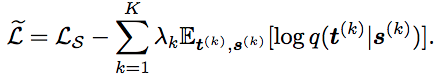

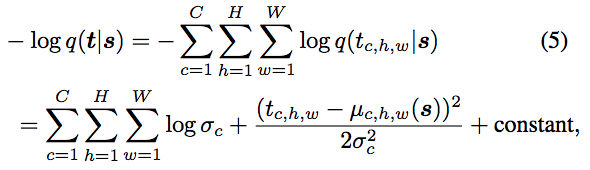

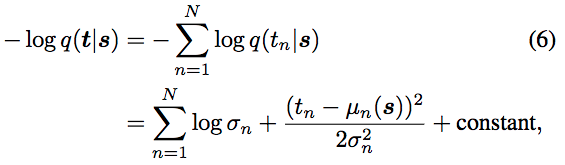

```
推导过程
```
高斯分布
$
\displaystyle\frac {1} {\sqrt {2π} σ} 
exp(- \displaystyle\frac {(x-μ)^2} {2σ^2})
$

求log

$
log \displaystyle\frac {1} {\sqrt {2π} σ} - \displaystyle\frac {(x-μ)^2} {2σ^2}
$

$
-logq(t|s) = - \displaystyle\sum_{c=1}^C\displaystyle\sum_{h=1}^H\displaystyle\sum_{w=1}^W logq(t_{c,h,w}|s)
= 
\displaystyle\sum_{c=1}^C\displaystyle\sum_{h=1}^H\displaystyle\sum_{w=1}^W logσ_c + \displaystyle\frac {(t_{c,h,w} - 𝑢_{c,h,w}(s))^2} {2𝑢_c^2}
$

In [ ]:
def conv1x1(in_channels, out_channels):
	return nn.Conv2d(in_channels, out_channels,
					 kernel_size=1, stride=1,
					 padding=0, bias=False)

'''
Modified from https://github.com/HobbitLong/RepDistiller/blob/master/distiller_zoo/VID.py
'''
class VID(nn.Module):
	'''
	Variational Information Distillation for Knowledge Transfer
	https://zpascal.net/cvpr2019/Ahn_Variational_Information_Distillation_for_Knowledge_Transfer_CVPR_2019_paper.pdf
	'''
	def __init__(self, in_channels, mid_channels, out_channels, init_var, eps=1e-6):
		super(VID, self).__init__()
		self.eps = eps
		self.regressor = nn.Sequential(*[
				conv1x1(in_channels, mid_channels),
				# nn.BatchNorm2d(mid_channels),
				nn.ReLU(),
				conv1x1(mid_channels, mid_channels),
				# nn.BatchNorm2d(mid_channels),
				nn.ReLU(),
				conv1x1(mid_channels, out_channels),
			])
		self.alpha = nn.Parameter(
				np.log(np.exp(init_var-eps)-1.0) * torch.ones(out_channels)
			)

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
			# elif isinstance(m, nn.BatchNorm2d):
			# 	nn.init.constant_(m.weight, 1)
			# 	nn.init.constant_(m.bias, 0)

	def forward(self, fm_s, fm_t):
		pred_mean = self.regressor(fm_s)
		pred_var  = torch.log(1.0+torch.exp(self.alpha)) + self.eps
		pred_var  = pred_var.view(1, -1, 1, 1)
		neg_log_prob = 0.5 * (torch.log(pred_var) + (pred_mean-fm_t)**2 / pred_var)
		loss = torch.mean(neg_log_prob)

		return loss

### OFD(overhaul of feature distillation)
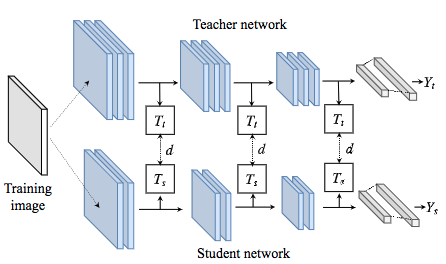

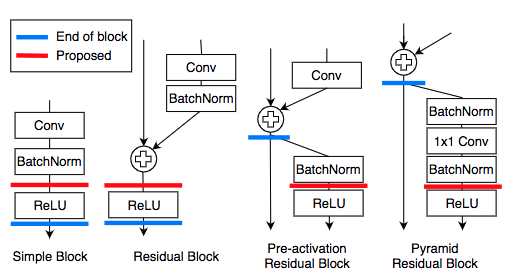

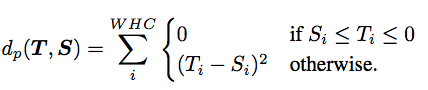
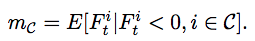

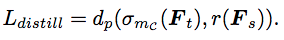

In [ ]:
'''
Modified from https://github.com/clovaai/overhaul-distillation/blob/master/CIFAR-100/distiller.py
'''
class OFD(nn.Module):
	'''
	A Comprehensive Overhaul of Feature Distillation
	http://openaccess.thecvf.com/content_ICCV_2019/papers/
	Heo_A_Comprehensive_Overhaul_of_Feature_Distillation_ICCV_2019_paper.pdf
	'''
	def __init__(self, in_channels, out_channels):
		super(OFD, self).__init__()
		self.connector = nn.Sequential(*[
				nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
				nn.BatchNorm2d(out_channels)
			])

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)

	def forward(self, fm_s, fm_t):
		margin = self.get_margin(fm_t)
		fm_t = torch.max(fm_t, margin)
		fm_s = self.connector(fm_s)

		mask = 1.0 - ((fm_s <= fm_t) & (fm_t <= 0.0)).float() # mask用来衡量是否满足条件 S_i <= T_i <= 0
		loss = torch.mean((fm_s - fm_t)**2 * mask) # (T_i - S_i) ^ 2

		return loss

	def get_margin(self, fm, eps=1e-6):
		mask = (fm < 0.0).float()
		masked_fm = fm * mask

		margin = masked_fm.sum(dim=(0,2,3), keepdim=True) / (mask.sum(dim=(0,2,3), keepdim=True)+eps)

		return margin

### AFD (attention feature distillation)

attention feature distillation and selection

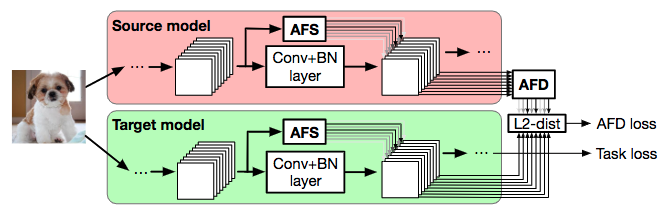

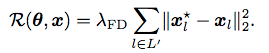

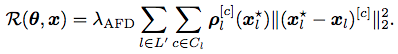

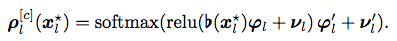

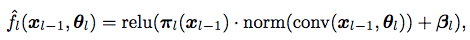

In [ ]:
import math

'''
In the original paper, AFD is one of components of AFDS.
AFDS: Attention Feature Distillation and Selection
AFD:  Attention Feature Distillation
AFS:  Attention Feature Selection
We find the original implementation of attention is unstable, thus we replace it with a SE block.
'''
class AFD(nn.Module):
	'''
	Pay Attention to Features, Transfer Learn Faster CNNs
	https://openreview.net/pdf?id=ryxyCeHtPB
	'''
	def __init__(self, in_channels, att_f):
		super(AFD, self).__init__()
		mid_channels = int(in_channels * att_f)

    # relu(...) 公式
		self.attention = nn.Sequential(*[
				nn.Conv2d(in_channels, mid_channels, 1, 1, 0, bias=True),
				nn.ReLU(inplace=True),
				nn.Conv2d(mid_channels, in_channels, 1, 1, 0, bias=True)
			])

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
		
	def forward(self, fm_s, fm_t, eps=1e-6):
    # attention matrix
		fm_t_pooled = F.adaptive_avg_pool2d(fm_t, 1)
		rho = self.attention(fm_t_pooled)
		# rho = F.softmax(rho.squeeze(), dim=-1)
    # softmax(relu(...)) 公式
		rho = torch.sigmoid(rho.squeeze())
		rho = rho / torch.sum(rho, dim=1, keepdim=True)

    # distillation loss
		fm_s_norm = torch.norm(fm_s, dim=(2,3), keepdim=True)
		fm_s      = torch.div(fm_s, fm_s_norm+eps)
		fm_t_norm = torch.norm(fm_t, dim=(2,3), keepdim=True)
		fm_t      = torch.div(fm_t, fm_t_norm+eps)

		loss = rho * torch.pow(fm_s-fm_t, 2).mean(dim=(2,3))
		loss = loss.sum(1).mean(0)

		return loss

### CRD(contrastive representation distillation)

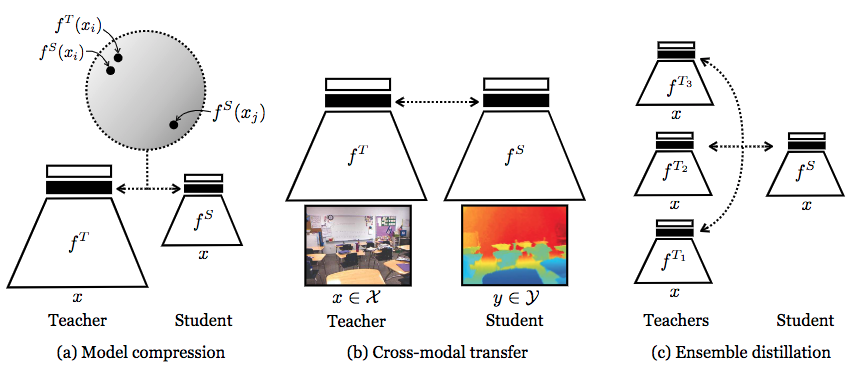

In [ ]:
'''
Modified from https://github.com/HobbitLong/RepDistiller/tree/master/crd
'''
class CRD(nn.Module):
	'''
	Contrastive Representation Distillation
	https://openreview.net/pdf?id=SkgpBJrtvS
	includes two symmetric parts:
	(a) using teacher as anchor, choose positive and negatives over the student side
	(b) using student as anchor, choose positive and negatives over the teacher side
	Args:
		s_dim: the dimension of student's feature
		t_dim: the dimension of teacher's feature
		feat_dim: the dimension of the projection space
		nce_n: number of negatives paired with each positive
		nce_t: the temperature
		nce_mom: the momentum for updating the memory buffer
		n_data: the number of samples in the training set, which is the M in Eq.(19)
	'''
	def __init__(self, s_dim, t_dim, feat_dim, nce_n, nce_t, nce_mom, n_data):
		super(CRD, self).__init__()
		self.embed_s = Embed(s_dim, feat_dim)
		self.embed_t = Embed(t_dim, feat_dim)
		self.contrast = ContrastMemory(feat_dim, n_data, nce_n, nce_t, nce_mom)
		self.criterion_s = ContrastLoss(n_data)
		self.criterion_t = ContrastLoss(n_data)

	def forward(self, feat_s, feat_t, idx, sample_idx):
		# student's and teacher's feature map representation
		feat_s = self.embed_s(feat_s)
		feat_t = self.embed_t(feat_t)
		out_s, out_t = self.contrast(feat_s, feat_t, idx, sample_idx)
		loss_s = self.criterion_s(out_s)
		loss_t = self.criterion_t(out_t)
		loss = loss_s + loss_t

		return loss


class Embed(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(Embed, self).__init__()
		self.linear = nn.Linear(in_dim, out_dim)

	def forward(self, x):
		x = x.view(x.size(0), -1)
		x = self.linear(x)
		x = F.normalize(x, p=2, dim=1)

		return x


class ContrastLoss(nn.Module):
	'''
	contrastive loss, corresponding to Eq.(18)
	'''
	def __init__(self, n_data, eps=1e-7):
		super(ContrastLoss, self).__init__()
		self.n_data = n_data
		self.eps = eps

	def forward(self, x):
		bs = x.size(0)
		N  = x.size(1) - 1
		M  = float(self.n_data)

		# loss for positive pair
		pos_pair = x.select(1, 0) # 选取第一个，是正样本
		log_pos  = torch.div(pos_pair, pos_pair.add(N / M + self.eps)).log_()

		# loss for negative pair
		neg_pair = x.narrow(1, 1, N)
		log_neg  = torch.div(neg_pair.clone().fill_(N / M), neg_pair.add(N / M + self.eps)).log_()

		loss = -(log_pos.sum() + log_neg.sum()) / bs

		return loss


class ContrastMemory(nn.Module):
	def __init__(self, feat_dim, n_data, nce_n, nce_t, nce_mom):
		super(ContrastMemory, self).__init__()
		self.N = nce_n
		self.T = nce_t
		self.momentum = nce_mom
		self.Z_t = None
		self.Z_s = None

		stdv = 1. / math.sqrt(feat_dim / 3.)
		self.register_buffer('memory_t', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))
		self.register_buffer('memory_s', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))

	def forward(self, feat_s, feat_t, idx, sample_idx):
		bs = feat_s.size(0)
		feat_dim = self.memory_s.size(1)
		n_data = self.memory_s.size(0)

		# using teacher as anchor
		weight_s = torch.index_select(self.memory_s, 0, sample_idx.view(-1)).detach()
		weight_s = weight_s.view(bs, self.N + 1, feat_dim)
		out_t = torch.bmm(weight_s, feat_t.view(bs, feat_dim, 1))
		out_t = torch.exp(torch.div(out_t, self.T)).squeeze().contiguous()

		# using student as anchor
		weight_t = torch.index_select(self.memory_t, 0, sample_idx.view(-1)).detach()
		weight_t = weight_t.view(bs, self.N + 1, feat_dim)
		out_s = torch.bmm(weight_t, feat_s.view(bs, feat_dim, 1))
		out_s = torch.exp(torch.div(out_s, self.T)).squeeze().contiguous()

		# set Z if haven't been set yet
		if self.Z_t is None:
			self.Z_t = (out_t.mean() * n_data).detach().item()
		if self.Z_s is None:
			self.Z_s = (out_s.mean() * n_data).detach().item()

		out_t = torch.div(out_t, self.Z_t)
		out_s = torch.div(out_s, self.Z_s)

		# update memory
		with torch.no_grad():
			pos_mem_t = torch.index_select(self.memory_t, 0, idx.view(-1))
			pos_mem_t.mul_(self.momentum)
			pos_mem_t.add_(torch.mul(feat_t, 1 - self.momentum))
			pos_mem_t = F.normalize(pos_mem_t, p=2, dim=1)
			self.memory_t.index_copy_(0, idx, pos_mem_t)

			pos_mem_s = torch.index_select(self.memory_s, 0, idx.view(-1))
			pos_mem_s.mul_(self.momentum)
			pos_mem_s.add_(torch.mul(feat_s, 1 - self.momentum))
			pos_mem_s = F.normalize(pos_mem_s, p=2, dim=1)
			self.memory_s.index_copy_(0, idx, pos_mem_s)

		return out_s, out_t

### DML(deep mutual learning)

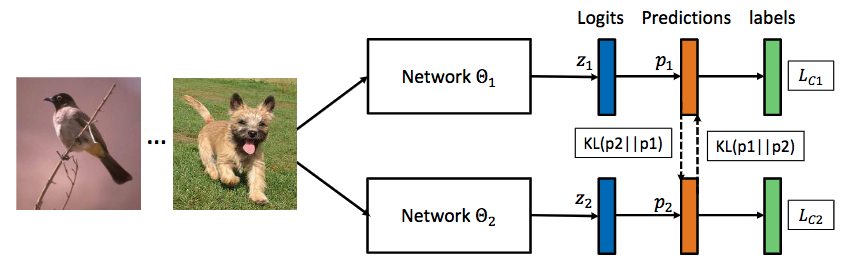

```
Specifically, each student is trained with
two losses: a conventional supervised learning loss, and a
mimicry loss that aligns each student’s class posterior with
the class probabilities of other students.

hard label loss + kl divergence with other students's logits
```

In [ ]:
'''
DML with only two networks
'''
class DML(nn.Module):
	'''
	Deep Mutual Learning
	https://zpascal.net/cvpr2018/Zhang_Deep_Mutual_Learning_CVPR_2018_paper.pdf
	'''
	def __init__(self):
		super(DML, self).__init__()

	def forward(self, out1, out2):
		loss = F.kl_div(F.log_softmax(out1, dim=1),
						F.softmax(out2, dim=1),
						reduction='batchmean')

		return loss

## Keras

In [ ]:
import tensorflow as tf

#### KL 散度

In [ ]:
kl = tf.keras.losses.KLDivergence()
kl(p,q).numpy()

0.3266309

In [ ]:
# 不对称
kl(q,p).numpy()

0.25020123

## **numpy**

### numpy axis问题

```
np.sum中的axis想要确定是哪个维度，就只要看去关注哪个维度是变化的即可
比如[[1,2,4],[2,3,5],[3,4,9]] 

np.sum(a,axis=1)
结果就是(a[0][0] + a[0][1] + a[0][2],a[1][0] + a[1][1] + a[1][2],a[2][0] + a[2][1] + a[2][2]) = (7,10,16)

np.sum(a,axis=0)

结果就是(a[0][0]+a[1][0]+a[2][0],a[0][1]+a[1][1]+a[2][1],a[0][2]+a[1][2]+a[2][2]) = (6,9,18)

再比如[[[1,2,3,4],[1,3,4,5]],[[2,4,7,5],[8,4,3,5]],[[2,5,7,3],[1,5,3,7]]]

np.sum(b,axis=0)
结果就是
      (a[0][0][0] + a[1][0][0] + a[2][0][0] = 5,
      a[0][0][1] + a[1][0][1] + a[2][0][1] = 11,
      a[0][0][2] + a[1][0][2] + a[2][0][2] = 17,
      a[0][0][3] + a[1][0][3] + a[2][0][3]) = 12,
      {a[0][1][0] + a[1][1][0] + a[2][1][0] = 10,
      a[0][1][1] + a[1][1][1] + a[2][1][1] = 12,
      a[0][1][2] + a[1][1][2] + a[2][1][2] = 10,
      a[0][1][3] + a[1][1][3] + a[2][1][3] = 17
      } = [[5,11,17,12],[10,12,10,17]]

哪个维度sum之后就会消失，比如(3,2,4) sum(axis=0) => (2,4)
```

In [ ]:
import numpy as np

In [ ]:
a = np.array([[1,2,4],[2,3,5],[3,4,9]])

In [ ]:
a

array([[1, 2, 4],
       [2, 3, 5],
       [3, 4, 9]])

In [ ]:
np.sum(a,axis=0)

array([ 6,  9, 18])

In [ ]:
b = np.array([[[1,2,3,4],[1,3,4,5]],[[2,4,7,5],[8,4,3,5]],[[2,5,7,3],[1,5,3,7]]])

In [ ]:
b.shape

(3, 2, 4)

In [ ]:
b

array([[[1, 2, 3, 4],
        [1, 3, 4, 5]],

       [[2, 4, 7, 5],
        [8, 4, 3, 5]],

       [[2, 5, 7, 3],
        [1, 5, 3, 7]]])

In [ ]:
np.sum(b,axis=0)

array([[ 5, 11, 17, 12],
       [10, 12, 10, 17]])

In [ ]:
data = np.random.randint(0, 5, [4,3,2,3])

In [ ]:
data

array([[[[3, 1, 1],
         [4, 0, 1]],

        [[0, 4, 2],
         [4, 2, 3]],

        [[4, 0, 4],
         [0, 2, 0]]],


       [[[2, 1, 4],
         [3, 3, 0]],

        [[1, 3, 1],
         [2, 3, 3]],

        [[4, 2, 0],
         [3, 3, 1]]],


       [[[3, 3, 4],
         [1, 4, 2]],

        [[0, 0, 0],
         [3, 1, 3]],

        [[2, 2, 1],
         [2, 4, 2]]],


       [[[0, 2, 4],
         [4, 1, 3]],

        [[0, 2, 1],
         [1, 0, 2]],

        [[2, 1, 3],
         [3, 1, 3]]]])

In [ ]:
np.sum(data,axis=0)

array([[[ 8,  7, 13],
        [12,  8,  6]],

       [[ 1,  9,  4],
        [10,  6, 11]],

       [[12,  5,  8],
        [ 8, 10,  6]]])

In [ ]:
np.average(data,axis=0)

array([[[2.  , 1.75, 3.25],
        [3.  , 2.  , 1.5 ]],

       [[0.25, 2.25, 1.  ],
        [2.5 , 1.5 , 2.75]],

       [[3.  , 1.25, 2.  ],
        [2.  , 2.5 , 1.5 ]]])

### numpy clip

In [ ]:
x = np.array([1,2,3,4,5,6,7,8,9])

```
numpy.clip(a,a_min,a_max,out=None)

a是一个数组，后面两个参数分别表示最小和最大值。
也就是说clip这个函数将将数组中的元素限制在a_min, a_max之间，大于a_max的就使得它等于 a_max，小于a_min,的就使得它等于a_min。
```

In [ ]:
np.clip(x,3,8)

array([3, 3, 3, 4, 5, 6, 7, 8, 8])

```
pytorch clamp

torch.clamp(input,min,max,out=None)

clamp函数表示夹紧，将input中的元素限制在min-max之间并返回一个tensor
```

In [ ]:
a = torch.Tensor([1,2,3,4,5,6,7,8,9])

a.clamp(3,8)

tensor([3., 3., 3., 4., 5., 6., 7., 8., 8.])

In [ ]:
b = torch.from_numpy(np.array([[1,2,3],[4,5,6]]))
print(b.shape)
b.unsqueeze(-1)

torch.Size([2, 3])


tensor([[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]])